In [1]:
import pandas as pd 
import numpy as np
import os
dataset_folder = '../dataset_new'

In [2]:
sensors = ['sensor2', 'sensor3', 'sensor4','sensor7','sensor8','sensor9','sensor11','sensor12','sensor13','sensor14',
           'sensor15','sensor17','sensor20', 'sensor21']

In [3]:
train = []
files = os.listdir(dataset_folder)
train_files = [file for file in files if file.startswith('scaled')]

for file in files: 
    path_to_file = dataset_folder + '/'+file
    df = pd.read_csv(path_to_file, index_col=0) #index_col = 0 perché sennò viene aggiunta la colonna unnamed. 
    train.append(df)

train[0].head()

,unit_number,time_cycle,op_setting1,op_setting2,op_setting3,RUL,sensor2,sensor3,sensor4,sensor6,...,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21
0,1.0,1.0,-0.0007,-0.0004,100.0,191.0,0.183735,0.406802,0.309757,1.0,...,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662
1,1.0,2.0,0.0019,-0.0003,100.0,190.0,0.283133,0.453019,0.352633,1.0,...,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014
2,1.0,3.0,-0.0043,0.0003,100.0,189.0,0.343373,0.369523,0.370527,1.0,...,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375
3,1.0,4.0,0.0007,0.0000,100.0,188.0,0.343373,0.256159,0.331195,1.0,...,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386
4,1.0,5.0,-0.0019,-0.0002,100.0,187.0,0.349398,0.257467,0.404625,1.0,...,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502


In [4]:
def process_targets(data_length, early_rul = None):
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [5]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    #Viene calcolato il numero di batch che saranno generati sulla base della grandezza dell'input 
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    
    #Si recupera il numero di features all'interno del dataframe
    num_features = input_data.shape[1]
    '''
    Qui, viene inizializzata una matrice output_data con valori NaN, che rappresenta i dati di output che verranno generati dalla funzione. 
    La matrice è inizialmente creata come una matrice 3D con dimensioni (num_batches, window_length, num_features) per contenere i batch di dati di input.
    '''
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    
    #Verfico che i labels siano stati forniti
    if target_data is None:
        
        #Iteriamo attraverso i batch e copiamo le finestre temporali corrispondenti dai dati di input input_data nella matrice output_data. 
        #L'output sarà quindi una matrice 3D con i batch di dati di input.

        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        #Nel caso in cui i dati siano forniti semplicemente facciamo la stessa cosa per i dati di target
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))] #Differente perché i dati di target sono formattati in altra maniera.
        return output_data, output_targets

In [6]:
#Configurazione

window_length = 30 #Lunghezza delle sequenze
shift = 1
early_rul = 125 #100 è il valore utilizzato comunemente dallo stato dell'arte             
processed_train_data = []
processed_train_targets = []

FD0001 = train[0]
unit_number_col = FD0001['unit_number']
num_train_machines_FD0001 = len(FD0001['unit_number'].unique())
FD0001 = FD0001[sensors]

In [7]:
new_FD0001 = pd.concat([unit_number_col, FD0001], axis= 1 )

In [8]:

for i in np.arange(1, num_train_machines_FD0001 + 1):
    temp_train_data = new_FD0001[new_FD0001['unit_number'] == i].drop(columns = ['unit_number']).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

In [9]:

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)

Processed trianing data shape:  (17731, 30, 14)
Processed training ruls shape:  (17731,)


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(processed_train_data, processed_train_targets, test_size=0.2, random_state=42)

In [11]:
from keras import backend as K 
import tensorflow as tf 
import math 

@tf.function
def custom_loss2(y_true, y_pred):
    alpha = 0.3 # 0.4 per la large !!!
    difference = y_pred - y_true
    squared_difference = tf.square(y_pred - y_true)
    
    # Calcola la loss per ciascun elemento
    loss = tf.where(difference < 0, 2 * alpha * squared_difference, 2 * (alpha + (1 - 2 * alpha)) * squared_difference)
    
    # Calcola la media delle loss
    return tf.reduce_mean(loss)

@tf.function
def custom_score(y_true, y_pred):
    d_i = y_pred - y_true
    #esponente = tf.where(d_i < 0, 1.0 / (d_i / 13.0), d_i / 10.0)
    sum = tf.reduce_sum(tf.where(d_i < 0, tf.exp(-d_i/13)-1, tf.exp(d_i/10)-1)) #prova
    #sum = tf.reduce_sum(tf.exp(esponente) - 1.0)
    return sum


# def compute_s_score(rul_true, rul_pred):
#     """
#     Both rul_true and rul_pred should be 1D numpy arrays.
#     """
#     diff = rul_pred - rul_true
#     return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

2023-11-09 22:30:42.692769: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-09 22:30:42.692808: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-09 22:30:42.692826: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-09 22:30:42.699001: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import Adam



def createLSTMlargeModel(l1Nodes, l2Nodes, l3Nodes, l4Nodes, d1dense , d2dense, input_shape): 
    lstm1 = LSTM(l1Nodes, input_shape=input_shape, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d1 = Dropout(0.2)
    lstm2 = LSTM(l2Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d2 = Dropout(0.2)
    lstm3 = LSTM(l3Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d3 = Dropout(0.2)
    lstm4 = LSTM(l4Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d4 = Dropout(0.2)

    flatten = Flatten()

    dense1 = Dense(d1dense,activation='relu', kernel_regularizer=regularizers.l2(0.1))
    dense2 = Dense(d2dense,activation='relu', kernel_regularizer=regularizers.l2(0.1))
    output_dense = Dense(1,activation='relu', kernel_regularizer=regularizers.l2(0.1))

    layers = [lstm1,d1, lstm2,d2, lstm3, d3, lstm4, d4,flatten,  dense1, dense2, output_dense]
   
    optimizer = Adam(learning_rate=0.01)
    model = Sequential(layers)
    model.compile(optimizer=optimizer, loss=custom_loss2, metrics = [custom_score])
    #model.compile(optimizer=optimizer, loss="mse", metrics = [custom_score])
    return model


2023-11-09 22:30:44.673938: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-09 22:30:44.680646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-09 22:30:44.680708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-09 22:30:44.682776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-09 22:30:44.682888: I tensorflow/compile

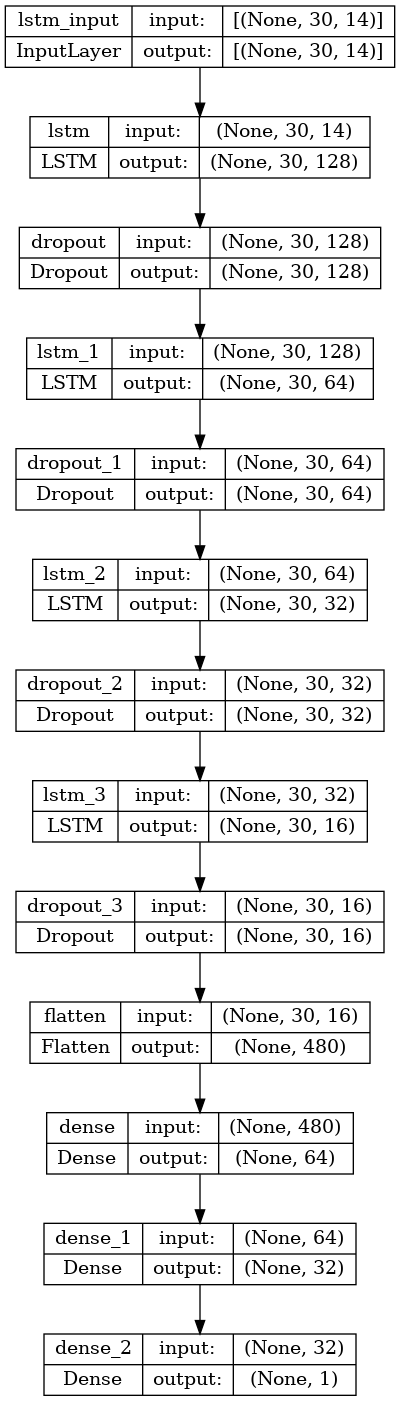

In [13]:
LSTMlargeModel= createLSTMlargeModel(128, 64, 32, 16, 64, 32, (30,14))
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
# Plot the model
plot_model(LSTMlargeModel, show_shapes=True, show_layer_names=True)

In [14]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    elif epoch >= 30 and epoch < 60 :
        return 0.001
    elif epoch >= 60 and epoch < 90: 
        return 0.0001
    elif epoch >= 90: 
        return 0.00001
    else: 
        return 0.01; 
    
# def scheduler(epoch):
#     if epoch < 5:
#         return 0.001
#     else:
#         return 0.0001
    

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model, save_model

EPOCHS = 100 

path_large = './models/LSTMlarge/FD0001'
model_checkpoint = ModelCheckpoint(
    path_large,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',

)
early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

history = LSTMlargeModel.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs = EPOCHS,
    batch_size = 256,
    use_multiprocessing =True, 
    callbacks=[model_checkpoint, lr_scheduler,early_stopping])



Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/100
56/56 [==============================] - ETA: 0s - loss: 1760.0770 - custom_score: 30659.3496
Epoch 1: val_loss improved from inf to 1647.38831, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


56/56 [==============================] - 10s 190ms/step - loss: 1760.0770 - custom_score: 30659.3496 - val_loss: 1647.3883 - val_custom_score: 18582.2461 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/100
55/56 [============================>.] - ETA: 0s - loss: 1648.1168 - custom_score: 21116.9688
Epoch 2: val_loss did not improve from 1647.38831
56/56 [==============================] - 1s 23ms/step - loss: 1647.5637 - custom_score: 20868.1738 - val_loss: 1664.0382 - val_custom_score: 18281.4766 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/100
55/56 [============================>.] - ETA: 0s - loss: 1012.7226 - custom_score: 10855.4189
Epoch 3: val_loss improved from 1647.38831 to 618.35260, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


56/56 [==============================] - 11s 195ms/step - loss: 1010.1744 - custom_score: 10699.7441 - val_loss: 618.3526 - val_custom_score: 3420.6597 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 4/100
55/56 [============================>.] - ETA: 0s - loss: 669.3478 - custom_score: 4941.8081
Epoch 4: val_loss improved from 618.35260 to 564.59827, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


56/56 [==============================] - 27s 487ms/step - loss: 669.4113 - custom_score: 4889.3726 - val_loss: 564.5983 - val_custom_score: 2957.7605 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 5/100
54/56 [===========================>..] - ETA: 0s - loss: 649.7781 - custom_score: 5042.6509
Epoch 5: val_loss did not improve from 564.59827
56/56 [==============================] - 1s 23ms/step - loss: 646.6237 - custom_score: 4931.5444 - val_loss: 566.6336 - val_custom_score: 3366.1960 - lr: 0.0100

Epoch 6: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 6/100
55/56 [============================>.] - ETA: 0s - loss: 559.0631 - custom_score: 3571.1008
Epoch 6: val_loss improved from 564.59827 to 490.15118, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


56/56 [==============================] - 10s 186ms/step - loss: 558.4825 - custom_score: 3524.9707 - val_loss: 490.1512 - val_custom_score: 2437.1450 - lr: 0.0100

Epoch 7: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 7/100
55/56 [============================>.] - ETA: 0s - loss: 531.9721 - custom_score: 3627.6055
Epoch 7: val_loss improved from 490.15118 to 436.42981, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


56/56 [==============================] - 11s 200ms/step - loss: 532.2099 - custom_score: 3587.3201 - val_loss: 436.4298 - val_custom_score: 1983.5764 - lr: 0.0100

Epoch 8: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 8/100
54/56 [===========================>..] - ETA: 0s - loss: 493.4759 - custom_score: 3059.1282
Epoch 8: val_loss did not improve from 436.42981
56/56 [==============================] - 1s 23ms/step - loss: 495.7814 - custom_score: 3077.0137 - val_loss: 514.0381 - val_custom_score: 3014.2500 - lr: 0.0100

Epoch 9: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 9/100
54/56 [===========================>..] - ETA: 0s - loss: 429.5662 - custom_score: 2329.5623
Epoch 9: val_loss improved from 436.42981 to 305.17340, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


56/56 [==============================] - 11s 196ms/step - loss: 426.3668 - custom_score: 2273.5989 - val_loss: 305.1734 - val_custom_score: 1226.6210 - lr: 0.0100

Epoch 10: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 10/100
55/56 [============================>.] - ETA: 0s - loss: 344.8303 - custom_score: 1598.0819
Epoch 10: val_loss did not improve from 305.17340
56/56 [==============================] - 1s 23ms/step - loss: 344.3201 - custom_score: 1577.0090 - val_loss: 405.1064 - val_custom_score: 1971.5482 - lr: 0.0100

Epoch 11: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 11/100
56/56 [==============================] - ETA: 0s - loss: 317.8872 - custom_score: 1339.2897
Epoch 11: val_loss improved from 305.17340 to 304.82034, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


56/56 [==============================] - 11s 201ms/step - loss: 317.8872 - custom_score: 1339.2897 - val_loss: 304.8203 - val_custom_score: 1218.9004 - lr: 0.0100

Epoch 12: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 12/100
55/56 [============================>.] - ETA: 0s - loss: 294.5292 - custom_score: 1211.3064
Epoch 12: val_loss improved from 304.82034 to 262.60681, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


56/56 [==============================] - 10s 181ms/step - loss: 294.3476 - custom_score: 1196.0579 - val_loss: 262.6068 - val_custom_score: 869.2264 - lr: 0.0100

Epoch 13: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 13/100
55/56 [============================>.] - ETA: 0s - loss: 252.3424 - custom_score: 953.0939
Epoch 13: val_loss improved from 262.60681 to 226.10815, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


56/56 [==============================] - 11s 196ms/step - loss: 252.3377 - custom_score: 943.9512 - val_loss: 226.1082 - val_custom_score: 796.5003 - lr: 0.0100

Epoch 14: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 14/100
54/56 [===========================>..] - ETA: 0s - loss: 270.3011 - custom_score: 1094.1030
Epoch 14: val_loss did not improve from 226.10815
56/56 [==============================] - 1s 22ms/step - loss: 270.3004 - custom_score: 1084.2478 - val_loss: 236.9276 - val_custom_score: 828.9705 - lr: 0.0100

Epoch 15: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 15/100
55/56 [============================>.] - ETA: 0s - loss: 263.8832 - custom_score: 1041.4233
Epoch 15: val_loss did not improve from 226.10815
56/56 [==============================] - 1s 23ms/step - loss: 263.3728 - custom_score: 1027.2340 - val_loss: 230.3720 - val_custom_score: 840.4616 - lr: 0.0100

Epoch 16: LearningRateScheduler setting learning

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


56/56 [==============================] - 11s 201ms/step - loss: 236.5073 - custom_score: 893.9438 - val_loss: 213.0339 - val_custom_score: 784.2156 - lr: 0.0100

Epoch 18: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 18/100
55/56 [============================>.] - ETA: 0s - loss: 251.4890 - custom_score: 999.2448 
Epoch 18: val_loss did not improve from 213.03392
56/56 [==============================] - 1s 22ms/step - loss: 251.4230 - custom_score: 987.5256 - val_loss: 229.7917 - val_custom_score: 899.4811 - lr: 0.0100

Epoch 19: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 19/100
54/56 [===========================>..] - ETA: 0s - loss: 232.1016 - custom_score: 881.1011
Epoch 19: val_loss did not improve from 213.03392
56/56 [==============================] - 1s 23ms/step - loss: 232.9279 - custom_score: 879.0295 - val_loss: 326.5053 - val_custom_score: 1402.1824 - lr: 0.0100

Epoch 20: LearningRateScheduler setting learning r

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


56/56 [==============================] - 11s 197ms/step - loss: 238.0217 - custom_score: 932.2007 - val_loss: 210.3405 - val_custom_score: 728.4343 - lr: 0.0100

Epoch 22: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 22/100
55/56 [============================>.] - ETA: 0s - loss: 224.9864 - custom_score: 842.6149
Epoch 22: val_loss did not improve from 210.34055
56/56 [==============================] - 1s 25ms/step - loss: 224.6055 - custom_score: 831.7207 - val_loss: 216.6924 - val_custom_score: 786.5123 - lr: 0.0100

Epoch 23: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 23/100
56/56 [==============================] - ETA: 0s - loss: 220.2017 - custom_score: 836.5425
Epoch 23: val_loss improved from 210.34055 to 205.31851, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


56/56 [==============================] - 11s 198ms/step - loss: 220.2017 - custom_score: 836.5425 - val_loss: 205.3185 - val_custom_score: 749.7608 - lr: 0.0100

Epoch 24: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 24/100
54/56 [===========================>..] - ETA: 0s - loss: 223.2421 - custom_score: 854.5887
Epoch 24: val_loss improved from 205.31851 to 200.55257, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


56/56 [==============================] - 10s 181ms/step - loss: 222.8608 - custom_score: 843.5154 - val_loss: 200.5526 - val_custom_score: 687.4429 - lr: 0.0100

Epoch 25: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 25/100
55/56 [============================>.] - ETA: 0s - loss: 222.7859 - custom_score: 859.0491
Epoch 25: val_loss did not improve from 200.55257
56/56 [==============================] - 1s 23ms/step - loss: 222.6895 - custom_score: 850.9522 - val_loss: 213.2228 - val_custom_score: 781.4489 - lr: 0.0100

Epoch 26: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 26/100
55/56 [============================>.] - ETA: 0s - loss: 230.7528 - custom_score: 914.7734
Epoch 26: val_loss did not improve from 200.55257
56/56 [==============================] - 1s 22ms/step - loss: 231.0484 - custom_score: 908.5889 - val_loss: 203.4358 - val_custom_score: 714.2228 - lr: 0.0100

Epoch 27: LearningRateScheduler setting learning rat

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


56/56 [==============================] - 12s 210ms/step - loss: 214.9220 - custom_score: 804.1085 - val_loss: 193.5958 - val_custom_score: 678.3786 - lr: 0.0100

Epoch 28: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 28/100
54/56 [===========================>..] - ETA: 0s - loss: 211.9931 - custom_score: 801.1979
Epoch 28: val_loss did not improve from 193.59578
56/56 [==============================] - 1s 24ms/step - loss: 212.6177 - custom_score: 796.3118 - val_loss: 207.5301 - val_custom_score: 720.1772 - lr: 0.0100

Epoch 29: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 29/100
55/56 [============================>.] - ETA: 0s - loss: 216.1705 - custom_score: 840.7296
Epoch 29: val_loss did not improve from 193.59578
56/56 [==============================] - 1s 23ms/step - loss: 216.4008 - custom_score: 833.8301 - val_loss: 246.4024 - val_custom_score: 987.9752 - lr: 0.0100

Epoch 30: LearningRateScheduler setting learning rat

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


56/56 [==============================] - 11s 194ms/step - loss: 216.2743 - custom_score: 825.7969 - val_loss: 193.3307 - val_custom_score: 716.4688 - lr: 0.0100

Epoch 31: LearningRateScheduler setting learning rate to 0.001.
Epoch 31/100
54/56 [===========================>..] - ETA: 0s - loss: 200.6325 - custom_score: 757.4725
Epoch 31: val_loss improved from 193.33073 to 188.79376, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


56/56 [==============================] - 12s 210ms/step - loss: 200.0936 - custom_score: 746.3475 - val_loss: 188.7938 - val_custom_score: 675.5529 - lr: 0.0010

Epoch 32: LearningRateScheduler setting learning rate to 0.001.
Epoch 32/100
55/56 [============================>.] - ETA: 0s - loss: 194.8568 - custom_score: 735.8193
Epoch 32: val_loss improved from 188.79376 to 188.10344, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


56/56 [==============================] - 11s 199ms/step - loss: 195.0309 - custom_score: 728.9586 - val_loss: 188.1034 - val_custom_score: 681.4200 - lr: 0.0010

Epoch 33: LearningRateScheduler setting learning rate to 0.001.
Epoch 33/100
55/56 [============================>.] - ETA: 0s - loss: 194.2626 - custom_score: 724.9911
Epoch 33: val_loss did not improve from 188.10344
56/56 [==============================] - 1s 22ms/step - loss: 194.2118 - custom_score: 716.9791 - val_loss: 190.5634 - val_custom_score: 677.7463 - lr: 0.0010

Epoch 34: LearningRateScheduler setting learning rate to 0.001.
Epoch 34/100
56/56 [==============================] - ETA: 0s - loss: 195.6820 - custom_score: 724.5194
Epoch 34: val_loss did not improve from 188.10344
56/56 [==============================] - 1s 24ms/step - loss: 195.6820 - custom_score: 724.5194 - val_loss: 189.4109 - val_custom_score: 685.7872 - lr: 0.0010

Epoch 35: LearningRateScheduler setting learning rate to 0.001.
Epoch 35/100
54/56

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


56/56 [==============================] - 11s 192ms/step - loss: 193.9322 - custom_score: 715.4652 - val_loss: 187.0790 - val_custom_score: 676.8379 - lr: 0.0010

Epoch 36: LearningRateScheduler setting learning rate to 0.001.
Epoch 36/100
55/56 [============================>.] - ETA: 0s - loss: 194.0931 - custom_score: 728.9033
Epoch 36: val_loss did not improve from 187.07898
56/56 [==============================] - 1s 25ms/step - loss: 193.9250 - custom_score: 720.8033 - val_loss: 195.7041 - val_custom_score: 714.5171 - lr: 0.0010

Epoch 37: LearningRateScheduler setting learning rate to 0.001.
Epoch 37/100
54/56 [===========================>..] - ETA: 0s - loss: 194.2046 - custom_score: 727.9419
Epoch 37: val_loss did not improve from 187.07898
56/56 [==============================] - 1s 24ms/step - loss: 193.4708 - custom_score: 715.4655 - val_loss: 188.5528 - val_custom_score: 682.9279 - lr: 0.0010

Epoch 38: LearningRateScheduler setting learning rate to 0.001.
Epoch 38/100
56/56

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


56/56 [==============================] - 11s 203ms/step - loss: 193.9148 - custom_score: 731.0742 - val_loss: 186.0818 - val_custom_score: 670.5885 - lr: 0.0010

Epoch 39: LearningRateScheduler setting learning rate to 0.001.
Epoch 39/100
56/56 [==============================] - ETA: 0s - loss: 192.4804 - custom_score: 720.0268
Epoch 39: val_loss did not improve from 186.08176
56/56 [==============================] - 2s 26ms/step - loss: 192.4804 - custom_score: 720.0268 - val_loss: 186.9475 - val_custom_score: 679.1500 - lr: 0.0010

Epoch 40: LearningRateScheduler setting learning rate to 0.001.
Epoch 40/100
55/56 [============================>.] - ETA: 0s - loss: 192.3660 - custom_score: 738.0022
Epoch 40: val_loss did not improve from 186.08176
56/56 [==============================] - 1s 23ms/step - loss: 192.2758 - custom_score: 729.3255 - val_loss: 195.2005 - val_custom_score: 698.7281 - lr: 0.0010

Epoch 41: LearningRateScheduler setting learning rate to 0.001.
Epoch 41/100
56/56

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


56/56 [==============================] - 11s 198ms/step - loss: 191.8489 - custom_score: 713.5106 - val_loss: 185.8302 - val_custom_score: 665.9532 - lr: 0.0010

Epoch 42: LearningRateScheduler setting learning rate to 0.001.
Epoch 42/100
55/56 [============================>.] - ETA: 0s - loss: 191.1099 - custom_score: 721.1594
Epoch 42: val_loss improved from 185.83022 to 185.55258, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


56/56 [==============================] - 11s 195ms/step - loss: 191.2176 - custom_score: 714.8138 - val_loss: 185.5526 - val_custom_score: 670.2557 - lr: 0.0010

Epoch 43: LearningRateScheduler setting learning rate to 0.001.
Epoch 43/100
55/56 [============================>.] - ETA: 0s - loss: 193.3742 - custom_score: 731.8369
Epoch 43: val_loss did not improve from 185.55258
56/56 [==============================] - 1s 23ms/step - loss: 193.6060 - custom_score: 726.2623 - val_loss: 187.0135 - val_custom_score: 670.1526 - lr: 0.0010

Epoch 44: LearningRateScheduler setting learning rate to 0.001.
Epoch 44/100
56/56 [==============================] - ETA: 0s - loss: 192.5729 - custom_score: 732.6666
Epoch 44: val_loss improved from 185.55258 to 184.54199, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


56/56 [==============================] - 11s 207ms/step - loss: 192.5729 - custom_score: 732.6666 - val_loss: 184.5420 - val_custom_score: 663.8963 - lr: 0.0010

Epoch 45: LearningRateScheduler setting learning rate to 0.001.
Epoch 45/100
55/56 [============================>.] - ETA: 0s - loss: 189.3432 - custom_score: 716.8825
Epoch 45: val_loss did not improve from 184.54199
56/56 [==============================] - 1s 24ms/step - loss: 189.3411 - custom_score: 708.7460 - val_loss: 188.1722 - val_custom_score: 671.1655 - lr: 0.0010

Epoch 46: LearningRateScheduler setting learning rate to 0.001.
Epoch 46/100
55/56 [============================>.] - ETA: 0s - loss: 191.2336 - custom_score: 721.8654
Epoch 46: val_loss did not improve from 184.54199
56/56 [==============================] - 1s 23ms/step - loss: 191.4505 - custom_score: 714.4570 - val_loss: 189.0364 - val_custom_score: 680.2164 - lr: 0.0010

Epoch 47: LearningRateScheduler setting learning rate to 0.001.
Epoch 47/100
55/56

INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


56/56 [==============================] - 10s 187ms/step - loss: 191.2734 - custom_score: 716.5336 - val_loss: 183.2522 - val_custom_score: 661.3525 - lr: 0.0010

Epoch 48: LearningRateScheduler setting learning rate to 0.001.
Epoch 48/100
54/56 [===========================>..] - ETA: 0s - loss: 191.3822 - custom_score: 722.6984
Epoch 48: val_loss did not improve from 183.25224
56/56 [==============================] - 1s 24ms/step - loss: 191.2263 - custom_score: 714.8294 - val_loss: 196.6494 - val_custom_score: 782.0114 - lr: 0.0010

Epoch 49: LearningRateScheduler setting learning rate to 0.001.
Epoch 49/100
54/56 [===========================>..] - ETA: 0s - loss: 191.0849 - custom_score: 728.0266
Epoch 49: val_loss improved from 183.25224 to 182.29356, saving model to ./models/LSTMlarge/FD0001
INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: ./models/LSTMlarge/FD0001/assets


56/56 [==============================] - 12s 209ms/step - loss: 191.2059 - custom_score: 719.6481 - val_loss: 182.2936 - val_custom_score: 667.5538 - lr: 0.0010

Epoch 50: LearningRateScheduler setting learning rate to 0.001.
Epoch 50/100
55/56 [============================>.] - ETA: 0s - loss: 190.0401 - custom_score: 720.1230
Epoch 50: val_loss did not improve from 182.29356
56/56 [==============================] - 1s 27ms/step - loss: 190.2865 - custom_score: 713.7039 - val_loss: 184.4920 - val_custom_score: 663.9725 - lr: 0.0010

Epoch 51: LearningRateScheduler setting learning rate to 0.001.
Epoch 51/100
54/56 [===========================>..] - ETA: 0s - loss: 188.5549 - custom_score: 717.4242
Epoch 51: val_loss did not improve from 182.29356
56/56 [==============================] - 1s 26ms/step - loss: 188.1672 - custom_score: 706.9462 - val_loss: 184.0253 - val_custom_score: 670.7030 - lr: 0.0010

Epoch 52: LearningRateScheduler setting learning rate to 0.001.
Epoch 52/100
56/56

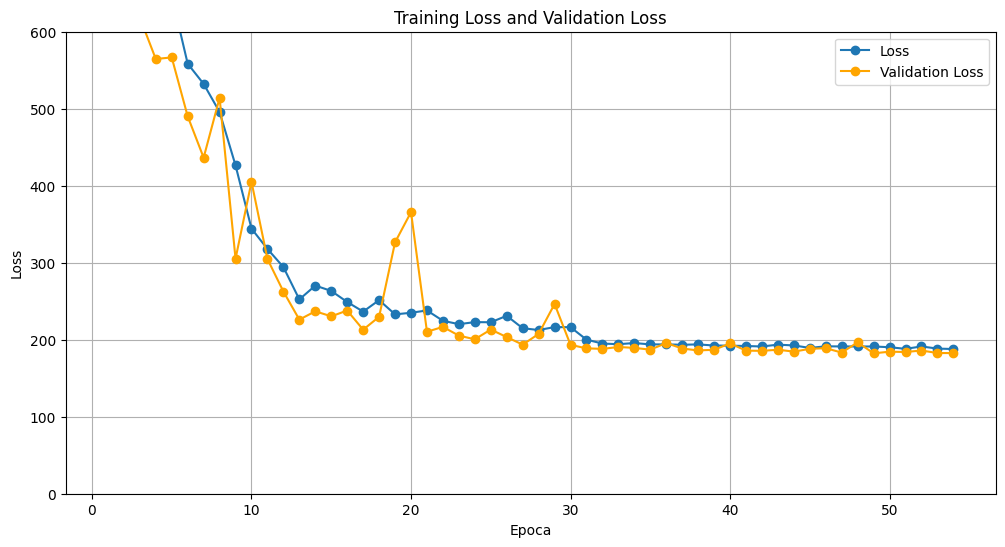

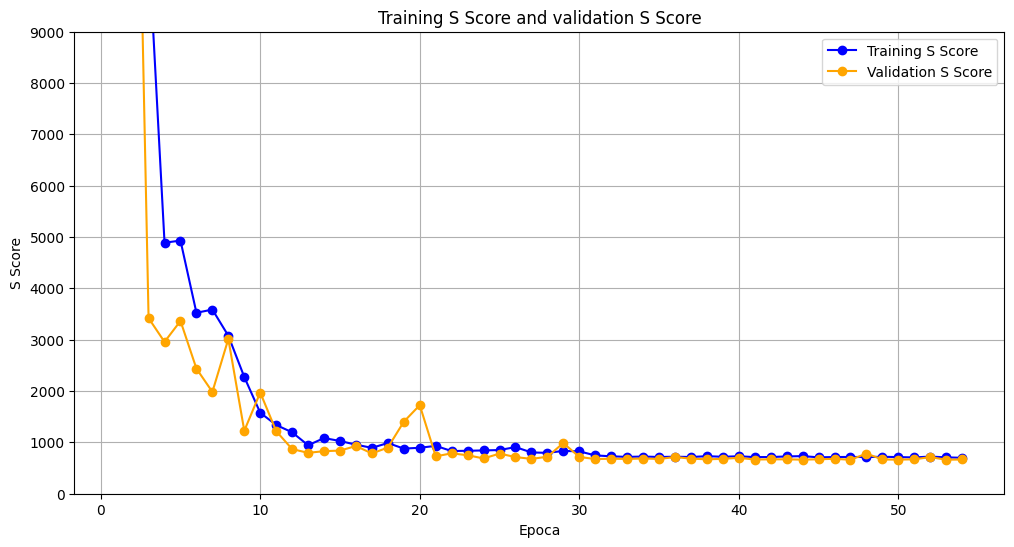

In [21]:
import matplotlib.pyplot as plt
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']


custom_score_values = history.history['custom_score']  
custom_score_validation_values = history.history['val_custom_score']


# Plot della loss function
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Loss', marker='o')
plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, label='Validation Loss', marker='o', linestyle='-', color='orange')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.ylim(0, 600)
plt.legend()
plt.grid(True)
plt.show()

# Plot della custom score
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(custom_score_values) + 1), custom_score_values, label='Training S Score', marker='o', color='blue')
plt.plot(range(1, len(custom_score_validation_values) + 1), custom_score_validation_values, label='Validation S Score', marker='o', color='orange')
plt.title('Training S Score and validation S Score')
plt.xlabel('Epoca')
plt.ylabel('S Score')
plt.ylim(0, 9000)
plt.legend()
plt.grid(True)
plt.show()


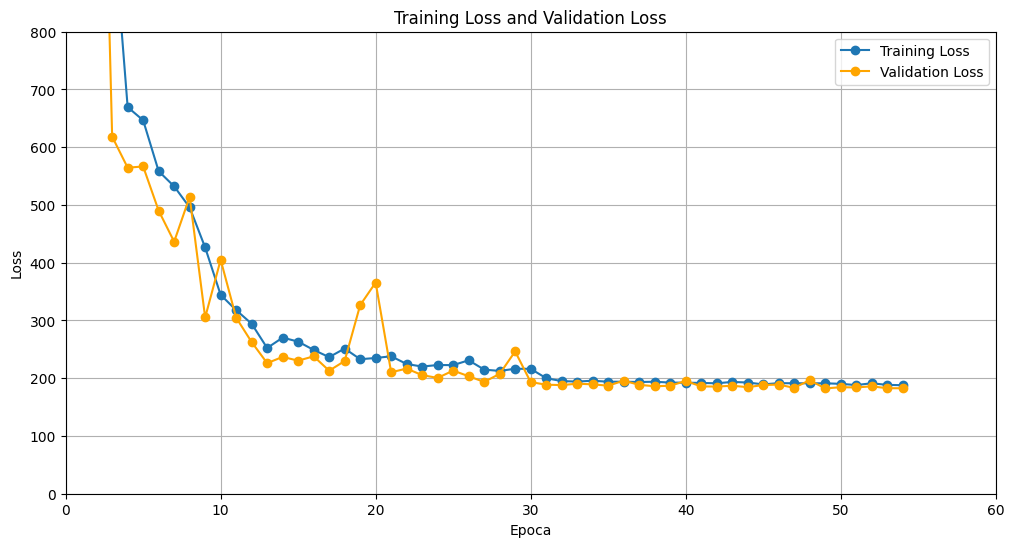

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, label='Validation Loss', marker='o', linestyle='-', color='orange')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.ylim(0,800)
plt.xlim(0,60)
plt.legend()
plt.grid(True)
plt.show()


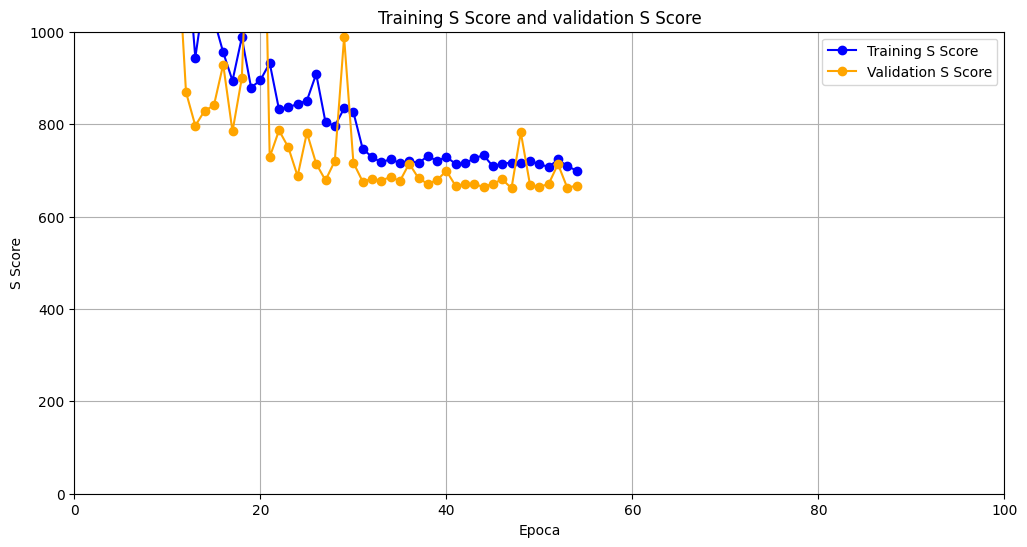

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(custom_score_values) + 1), custom_score_values, label='Training S Score', marker='o', color='blue')
plt.plot(range(1, len(custom_score_validation_values) + 1), custom_score_validation_values, label='Validation S Score', marker='o', color='orange')
plt.title('Training S Score and validation S Score')
plt.xlabel('Epoca')
plt.ylabel('S Score')
plt.ylim(0,1000)
plt.xlim(0,100)
plt.legend()
plt.grid(True)
plt.show()

In [19]:
### FUNZIONA
MODEL_DIR = '/home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMlarge/FD0001'
run_model = tf.function(lambda x: LSTMlargeModel(x))
BATCH_SIZE = 1
STEPS = 30
INPUT_SIZE = 14

concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], LSTMlargeModel.inputs[0].dtype)
)
converter = tf.lite.TFLiteConverter.from_keras_model(LSTMlargeModel)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]


LSTMlargeModel.save(MODEL_DIR, save_format="tf", signatures = concrete_func )

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

with open("large_lstm_fixed_batch_1.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMlarge/FD0001/assets


INFO:tensorflow:Assets written to: /home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMlarge/FD0001/assets
2023-11-09 22:31:27.617830: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-11-09 22:31:27.617864: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-11-09 22:31:27.618181: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMlarge/FD0001
2023-11-09 22:31:27.644952: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-11-09 22:31:27.644981: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMlarge/FD0001
2023-11-09 22:31:27.690804: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
